<a href="https://colab.research.google.com/github/EvgeniiaNovolodskaia/Seq2Seq-TextPredictor/blob/main/Seq2Seq_TextPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports PyTorch.
import torch

Downloading the dataset
==

We have to pre-process the dataset a little bit in order to remove everything that is not part of the text and to split the actual text into paragraphs.

In [ ]:
use_toy_dataset = False # If True, a toy dataset (see below) is used, instead of the "real" one.

In [ ]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt")
filename = tmp[0]
print(filename)

/tmp/tmpufml613e


In [ ]:
# Example
with open(filename) as f:
  for i in range(200):
    print(f"[{i}] {f.readline()}", end='')

[0] ﻿The Project Gutenberg eBook of Madame Bovary
[1]     
[2] This ebook is for the use of anyone anywhere in the United States and
[3] most other parts of the world at no cost and with almost no restrictions
[4] whatsoever. You may copy it, give it away or re-use it under the terms
[5] of the Project Gutenberg License included with this ebook or online
[6] at www.gutenberg.org. If you are not located in the United States,
[7] you will have to check the laws of the country where you are located
[8] before using this eBook.
[9] 
[10] Title: Madame Bovary
[11] 
[12] Author: Gustave Flaubert
[13] 
[14] Release date: November 26, 2004 [eBook #14155]
[15]                 Most recently updated: December 18, 2020
[16] 
[17] Language: French
[18] 
[19] Credits: Produced by Ebooks libres et gratuits at http://www.ebooksgratuits.com
[20] 
[21] 
[22] *** START OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY ***
[23] 
[24] 
[25] 
[26] 
[27] Produced by Ebooks libres et gratuits at http://www.ebooksg

In [ ]:
import re # Regular expression library
roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.

with open(filename) as f:
  skip = 2
  while(skip > 0):
    line = f.readline().strip()
    if(line == "PREMIÈRE PARTIE"): skip -= 1;

  paragraphs = []
  paragraph_buffer = []
  while(True):
    line = f.readline().strip()
    if("END OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY" in line): break # End of the actual text.

    if(line == ""):
      if(len(paragraph_buffer) > 0):
        paragraph_buffer.append(EOP) # End of the paragraph.

        paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
        paragraphs.append(paragraph)
        paragraph_buffer = []
      continue

    if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
    if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

    if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ')
    paragraph_buffer.append(line)

print(f"{len(paragraphs)} paragraphs read.")
for i in range(3): print(paragraphs[i], end='')

2995 paragraphs read.
Nous étions à l'Étude, quand le Proviseur entra, suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre. Ceux qui dormaient se réveillèrent, et chacun se leva comme surpris dans son travail.
Le Proviseur nous fit signe de nous rasseoir; puis, se tournant vers le maître d'études:
-- Monsieur Roger, lui dit-il à demi-voix, voici un élève que je vous recommande, il entre en cinquième. Si son travail et sa conduite sont méritoires, il passera dans les grands, où l'appelle son âge.


Toy dataset to experiment and firstly learn a model more easily

In [ ]:
if(use_toy_dataset):
  paragraphs = []

  import random, string
  characters = list(string.ascii_lowercase + string.ascii_lowercase.upper() + "_-/\'[]()")
  random.shuffle(characters)
  k = random.randint(1, 10)
  a = "a"
  paragraph = (a * k)
  for _ in range(100):
    random.shuffle(characters)
    for a in characters:
      k = random.randint(1, 16)
      paragraph += f"? Now, please write {k} {a}.{EOP}"
      paragraphs.append(paragraph)
      paragraph = (a * k)
  print(f"{len(paragraphs)} paragraphs generated.")

  print(paragraphs[:10])

In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
char_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for char in paragraph: char_counts[char] += 1

print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True)) # Shows each character with its frequency, in decreasing frequency order.

94 different characters found in the dataset.
[(' ', 109336), ('e', 76369), ('a', 44997), ('s', 42972), ('t', 38893), ('i', 38322), ('n', 35099), ('r', 34314), ('l', 33711), ('u', 32914), ('o', 27415), ('d', 19187), ('c', 14786), ('m', 14638), ('p', 13790), (',', 12378), ('v', 8441), ('é', 8263), ("'", 7451), ('.', 6225), ('b', 5519), ('q', 5455), ('f', 5406), ('h', 5386), ('g', 4704), ('-', 4243), ('\n', 2995), ('à', 2722), ('x', 2057), ('j', 1728), ('è', 1644), ('y', 1619), ('!', 1512), ('E', 1477), (';', 1425), ('ê', 1188), ('L', 981), ('C', 945), ('I', 769), ('M', 743), ('z', 674), ('A', 543), ('?', 530), (':', 480), ('ç', 470), ('B', 427), ('â', 410), ('P', 394), ('î', 327), ('R', 319), ('D', 313), ('O', 301), ('S', 298), ('ô', 296), ('ù', 293), ('H', 270), ('û', 241), ('Q', 237), ('J', 233), ('T', 211), ('V', 181), ('N', 155), ('U', 122), ('«', 120), ('»', 112), ('À', 84), ('F', 84), ('Y', 80), ('_', 64), ('G', 62), ('(', 55), (')', 55), ('ï', 37), ('É', 25), ('k', 16), ('1', 16)

In [ ]:
id_to_char = list(char_counts.keys()) # list of unique characters
char_vocabulary = {c: i for i, c in enumerate(id_to_char)} # dictionary mapping characters to ids


In [ ]:
EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol

print(char_vocabulary)
print(id_to_char)
print(f"EOP_id = {EOP_id}")

# Implementation of the test that proves that implementations of 'char_vocabulary' and 'id_to_char' are consistent.

def test_mappings_consistency(char_vocabulary, id_to_char):
  for i, char in enumerate(id_to_char):
    if char_vocabulary[char] != i:
      return False
  return True

print("Testing mappings consistency...")
consistency_result = test_mappings_consistency(char_vocabulary, id_to_char)
print(f"Are 'char_vocabulary' and 'id_to_char' consistent? {consistency_result}")

{'N': 0, 'o': 1, 'u': 2, 's': 3, ' ': 4, 'é': 5, 't': 6, 'i': 7, 'n': 8, 'à': 9, 'l': 10, "'": 11, 'É': 12, 'd': 13, 'e': 14, ',': 15, 'q': 16, 'a': 17, 'P': 18, 'r': 19, 'v': 20, 'h': 21, 'b': 22, 'g': 23, 'ç': 24, 'c': 25, 'p': 26, '.': 27, 'C': 28, 'x': 29, 'm': 30, 'è': 31, '\n': 32, 'L': 33, 'f': 34, ';': 35, 'î': 36, ':': 37, '-': 38, 'M': 39, 'R': 40, 'j': 41, 'S': 42, 'ù': 43, 'â': 44, 'z': 45, 'I': 46, 'Q': 47, 'û': 48, 'ê': 49, 'O': 50, 'y': 51, 'k': 52, 'ï': 53, 'E': 54, 'T': 55, 'U': 56, 'D': 57, '!': 58, '(': 59, ')': 60, 'B': 61, '?': 62, '_': 63, 'G': 64, '1': 65, '8': 66, '2': 67, 'A': 68, 'À': 69, 'H': 70, 'ô': 71, 'V': 72, 'Ê': 73, '«': 74, '»': 75, 'Y': 76, 'F': 77, 'J': 78, 'ë': 79, 'W': 80, 'X': 81, '0': 82, '5': 83, '7': 84, '9': 85, '6': 86, '3': 87, 'w': 88, 'Î': 89, 'Ç': 90, '4': 91, 'ü': 92, '°': 93}
['N', 'o', 'u', 's', ' ', 'é', 't', 'i', 'n', 'à', 'l', "'", 'É', 'd', 'e', ',', 'q', 'a', 'P', 'r', 'v', 'h', 'b', 'g', 'ç', 'c', 'p', '.', 'C', 'x', 'm', 'è', '

In [ ]:
# Turns a list of lists of ids into a list of strings.

def ids_to_texts(ids):
  result_texts = []
  for seq in ids:
    chars = []
    for char_id in seq:
      if char_id == EOP_id:
        break
      chars.append(id_to_char[char_id])
    result_texts.append("".join(chars))
  return result_texts

In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}")

[[61, 1, 8, 41, 1, 2, 19, 27], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, len(char_vocabulary), len(char_vocabulary)])
print(ids)
print(ids_to_texts(ids))
print(f"'ids_to_texts(ids) == ps' should be True: {ids_to_texts(ids) == ps}")

[[61, 1, 8, 41, 1, 2, 19, 27, 32, 94, 94], [28, 1, 30, 30, 14, 8, 6, 4, 17, 10, 10, 14, 45, 4, 20, 1, 2, 3, 4, 62]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids) == ps' should be True: True


Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
class BatchGenerator:

  def __init__(self, paragraphs, char_vocabulary):
    self.paragraphs = paragraphs
    self.char_vocabulary = char_vocabulary # dict[str, int]
    self.padding_idx = len(char_vocabulary)

  def length(self):
    return (len(self.paragraphs) - 1)

  def get_batch(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())
    paragraph_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some paragraph ids.

    return self._ids_to_batch(paragraph_ids)

  # paragraph_ids: sequence of int·s
  def _ids_to_batch(self, paragraph_ids):
    firsts = [] # list[list[int]]; first paragraph of each pair
    seconds = [] # list[list[int]], second paragraph of each pair
    for paragraph_id in paragraph_ids:
      firsts.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id]])
      seconds.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id + 1]])

    # Padding
    self.pad(firsts)
    self.pad(seconds)

    firsts = torch.tensor(firsts, dtype=torch.long)
    seconds = torch.tensor(seconds, dtype=torch.long)

    return (firsts, seconds)

  def pad(self, sequences):
    max_length = max([len(s) for s in sequences])
    for s in sequences: s.extend([self.padding_idx] * (max_length - len(s)))

  def all_batches(self, batch_size, subset=None):
    max_i = self.length() if(subset is None) else min(subset, self.length())

    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(instance_ids)
      i += batch_size

    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(instance_ids)

  def turn_into_batch(self, paragraphs):
    firsts = []
    for paragraph in paragraphs:
        tmp = [] # list[int]
        for char in paragraph:
          # Unknown characters are ignored (removed).
          if(char in self.char_vocabulary): tmp.append(self.char_vocabulary[char])

        if(tmp[-1] != EOP_id): tmp.append(EOP_id) # Adds an end-of-paragraph character if necessary.

        firsts.append(tmp)

    self.pad(firsts)
    return torch.tensor(firsts, dtype=torch.long)

batch_generator = BatchGenerator(paragraphs=paragraphs, char_vocabulary=char_vocabulary)
print(batch_generator.length())

2994


In [ ]:
(firsts, seconds) = batch_generator.get_batch(3)
print(ids_to_texts(firsts))
print(ids_to_texts(seconds))

["Il venait offrir ses services, eu égard à la fatale circonstance. Emma répondit qu'elle croyait pouvoir s'en passer. Le marchand ne se tint pas pour battu.", "Et il agita son journal en les regardant s'éloigner.", "L'idée de revoir les lieux où s'était passée sa jeunesse l'exaltait sans doute, car tout le long du chemin il n'arrêta pas de discourir; puis, à peine arrivé, il sauta vivement de la voiture pour se mettre en quête de Léon; et le clerc eut beau se débattre, M. Homais l'entraîna vers le grand café de Normandie, où il entra majestueusement sans retirer son chapeau, estimant fort provincial de se découvrir dans un endroit public."]
['-- Mille excuses, dit-il; je désirerais avoir un entretien particulier.', "Dès qu'il sentit la terre, le cheval d'Emma prit le galop. Rodolphe galopait à côté d'elle. Par moments ils échangeaient une parole. La figure un peu baissée, la main haute et le bras droit déployé, elle s'abandonnait à la cadence du mouvement qui la berçait sur la selle."

The model
==

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, size_vocabulary, EOP_id, embedding_dim, lstm_hidden_size, lstm_layers, device='cpu'):
    super().__init__()

    self.device = device

    self.EOP_id = EOP_id

    # (i) Embedding layer:
    self.padding_idx = size_vocabulary
    self.char_embeddings = torch.nn.Embedding(
        num_embeddings=size_vocabulary + 1,
        embedding_dim=embedding_dim,
        padding_idx=self.padding_idx
    ).to(self.device)

    # (ii) Bidirectional LSTM encoder:
    self.encoder_lstm = torch.nn.LSTM(
        input_size=embedding_dim,
        hidden_size=lstm_hidden_size,
        num_layers=lstm_layers,
        batch_first=True,
        bidirectional=True
    ).to(self.device)

    # (iii) Unidirectional LSTM decoder:
    self.decoder_lstm = torch.nn.LSTM(
        input_size=embedding_dim,
        hidden_size=lstm_hidden_size,
        num_layers=lstm_layers,
        batch_first=True,
        bidirectional=False
    ).to(self.device)

    # (iv) Decoder initialiser:
    self.decoder_initialiser = torch.nn.Linear(
        in_features=lstm_hidden_size * 2,
        out_features=lstm_hidden_size
    ).to(self.device)

    # (v) Distribution layer:
    self.distribution_nn = torch.nn.Sequential(
        torch.nn.Linear(lstm_hidden_size, size_vocabulary),
        torch.nn.LogSoftmax(dim=-1)
    ).to(self.device)

  def initStates(self, in_paragraphs):
    batch_size = in_paragraphs.size(0)

    in_char_embeddings = self.char_embeddings(in_paragraphs) # Shape: (batch_size, max length, embedding size)
    in_lengths = (in_paragraphs != self.char_embeddings.padding_idx).sum(axis=1)
    in_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=in_char_embeddings, lengths=in_lengths.cpu(), batch_first=True, enforce_sorted=False)

    _, (h_n, c_n) = self.encoder_lstm(in_char_embeddings)

    # Concatenates the left-to-right and right-to-left final hidden states of the biLSTM.
    h_n = h_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(h_n); print(h_n.shape)
    lr_h_n = h_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_h_n = h_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_h_n = torch.cat([lr_h_n, rl_h_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_h_n); print(bi_h_n.shape)

    # Concatenates the left-to-right and right-to-left final cell states of the biLSTM.
    c_n = c_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(c_n); print(c_n.shape)
    lr_c_n = c_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_c_n = c_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_c_n = torch.cat([lr_c_n, rl_c_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_c_n); print(bi_c_n.shape)

    return (self.decoder_initialiser(bi_h_n), self.decoder_initialiser(bi_c_n))

  def trainingLogits(self, in_paragraphs, out_paragraphs):
    decoder_init_states = self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    h_initial, c_initial = decoder_init_states  # Shapes: (num_layers, batch_size, hidden_size) each

    initial_logits = self.distribution_nn(h_initial[-1])  # (batch_size, vocab_size)
    initial_logits = initial_logits.unsqueeze(1)  # (batch_size, 1, vocab_size)

    # Prepare decoder inputs: out_paragraphs[:, :-1] are the tokens before the last one (teacher forcing).
    decoder_input = out_paragraphs[:, :-1]  # shape: (batch_size, max_out_len-1)
    out_embeddings = self.char_embeddings(decoder_input)  # (batch_size, seq_len, embedding_dim)

    # Compute lengths for packed sequence (excluding padding_idx).
    out_lengths = (decoder_input != self.char_embeddings.padding_idx).sum(axis=1)  # (batch_size)
    out_embeddings_packed = torch.nn.utils.rnn.pack_padded_sequence(out_embeddings, lengths=out_lengths.cpu(), batch_first=True, enforce_sorted=False)

    # Run the decoder LSTM
    decoder_out_packed, _ = self.decoder_lstm(out_embeddings_packed, (h_initial, c_initial))

    # Unpack the sequences
    decoder_out, _ = torch.nn.utils.rnn.pad_packed_sequence(decoder_out_packed, batch_first=True)
    # decoder_out shape: (batch_size, seq_len, hidden_size)

    # Compute distributions for each time step in decoder_out
    decoder_logits = self.distribution_nn(decoder_out)  # (batch_size, seq_len, vocab_size)

    # Concatenate initial_logits with decoder_logits
    logits = torch.cat([initial_logits, decoder_logits], dim=1)  # (batch_size, seq_len+1, vocab_size)

    return logits


  def predictionStrings(self, in_paragraphs, max_predicted_char=1000):
    batch_size = in_paragraphs.size(0)

    decoder_init_states = self.initStates(in_paragraphs)

    h_initial, c_initial = decoder_init_states  # (num_layers, batch_size, hidden_size) each
    batch_size = in_paragraphs.size(0)

    # Storage for generated characters and log-probabilities
    char_ids = []
    logprobs = torch.zeros(batch_size, device=self.device)

    # Compute initial logits
    initial_logits = self.distribution_nn(h_initial[-1])  # (batch_size, vocab_size)
    # Greedy selection of the first character
    first_char = torch.argmax(initial_logits, dim=1)  # (batch_size)
    char_ids.append(first_char)

    # Gather log-prob for the chosen character
    first_char_logprob = initial_logits.gather(1, first_char.unsqueeze(1)).squeeze(1)  # (batch_size)
    logprobs += first_char_logprob

    # Current decoder states
    h_current, c_current = h_initial, c_initial

    # Current input character for the decoder is the chosen first_char
    current_char = first_char.unsqueeze(1)  # (batch_size, 1)

    # Generate subsequent characters
    for _ in range(max_predicted_char - 1):
      # Embed the current character
      current_char_emb = self.char_embeddings(current_char)  # (batch_size, 1, embedding_dim)

      # Pass it through the decoder
      decoder_out, (h_current, c_current) = self.decoder_lstm(current_char_emb, (h_current, c_current))
      # decoder_out: (batch_size, 1, hidden_size)

      # Compute distribution
      step_logits = self.distribution_nn(decoder_out.squeeze(1))  # (batch_size, vocab_size)
      # Greedy selection of next character
      next_char = torch.argmax(step_logits, dim=1)  # (batch_size)

      # Append next_char to char_ids
      char_ids.append(next_char)

      # Gather log-prob for the chosen character
      step_logprob = step_logits.gather(1, next_char.unsqueeze(1)).squeeze(1)  # (batch_size)
      logprobs += step_logprob

      # Update current_char
      current_char = next_char.unsqueeze(1)

      # Stop if all sequences ended
      if (next_char == self.EOP_id).all():
        break

    # Convert char_ids (list of length T with tensors of shape (batch_size)) to a (batch_size, T) tensor
    char_ids = torch.stack(char_ids, dim=1)  # (batch_size, seq_length)

    # Convert IDs to texts
    texts = ids_to_texts(char_ids.cpu().numpy())  # List[str] of length batch_size

    return texts, logprobs  # List[str], Tensor[float]

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=19, lstm_hidden_size=13, lstm_layers=7, device='cuda')

In [ ]:
# Tests the training method.
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 0))]).to(model.device) # A batch that contains only one sentence with no padding.
print(in_paragraphs)

out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(f"logits:\n{logits}\n")

tensor([[0, 1, 2, 3, 4]], device='cuda:0')
logits:
tensor([[[-4.4215, -4.4793, -4.4751, -4.6891, -4.7921, -4.6214, -4.4352,
          -4.2475, -4.7300, -4.7387, -4.7140, -4.5036, -4.6740, -4.4603,
          -4.3544, -4.4323, -4.5620, -4.3372, -4.3993, -4.4632, -4.2614,
          -4.7583, -4.8507, -4.4887, -4.4829, -4.8096, -4.4013, -4.3509,
          -4.5843, -4.3103, -4.5214, -4.6296, -4.4320, -4.6118, -4.4104,
          -4.4667, -4.7839, -4.6559, -4.3442, -4.3667, -4.7344, -4.8644,
          -4.3967, -4.2981, -4.4585, -4.3590, -4.6204, -4.7793, -4.4302,
          -4.2422, -4.3399, -4.6321, -4.3782, -4.7910, -4.8586, -4.5245,
          -4.5083, -4.3943, -4.8245, -4.5321, -4.3653, -4.7984, -4.8495,
          -4.7530, -4.5563, -4.2409, -4.8063, -4.8116, -4.3400, -4.7272,
          -4.5926, -4.3218, -4.4756, -4.5114, -4.5680, -4.7000, -4.7760,
          -4.2920, -4.3251, -4.5537, -4.8072, -4.5320, -4.3566, -4.8008,
          -4.7067, -4.5939, -4.5739, -4.8739, -4.4575, -4.7493, -4.6235,


In [ ]:
# Checks that a tensor is a tensor of logits, i.e. that each vector is a vector of log-probabilities.
def check_logits(logits):

  # Convert from log probabilities to probabilities
  probs = torch.exp(logits)
  # Sum probabilities along the last dimension
  row_sums = probs.sum(dim=-1)
  # Check if all sums are close to 1 within a numerical tolerance
  return torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-5, rtol=1e-5)

print(f"The following should be True: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.6, 2.0], [0.1, 0.2, 0.7]])))}")
print(f"The following should be False: {check_logits(torch.log(torch.tensor([[0.5, 0.3, 0.2], [0.1, 0.2, 0.9]])))}")

The following should be True: True
The following should be False: False
The following should be False: False
The following should be False: False


In [ ]:
print(f"The following should be True: {check_logits(logits)}")

The following should be True: True


In [ ]:
# Tests the training method (again).
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 10)), (list(range(10)) + ([batch_generator.padding_idx] * 5))]).to(model.device) # A batch that contains two sentences with some padding (more than necessary).
print(in_paragraphs)
out_paragraphs = in_paragraphs
logits = model.trainingLogits(in_paragraphs, out_paragraphs)
print(logits)

print(f"The following should be True: {check_logits(logits)}")

tensor([[ 0,  1,  2,  3,  4, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 94, 94, 94, 94, 94]],
       device='cuda:0')
tensor([[[-4.4215, -4.4793, -4.4751,  ..., -4.7512, -4.6263, -4.7477],
         [-4.3166, -4.4929, -4.5326,  ..., -4.6538, -4.7010, -4.6892],
         [-4.2882, -4.5022, -4.5525,  ..., -4.6491, -4.7248, -4.6697],
         ...,
         [-4.3327, -4.4988, -4.4922,  ..., -4.6600, -4.7188, -4.7048],
         [-4.3327, -4.4988, -4.4922,  ..., -4.6600, -4.7188, -4.7048],
         [-4.3327, -4.4988, -4.4922,  ..., -4.6600, -4.7188, -4.7048]],

        [[-4.4151, -4.4808, -4.4845,  ..., -4.7503, -4.6277, -4.7437],
         [-4.3127, -4.4936, -4.5378,  ..., -4.6536, -4.7022, -4.6873],
         [-4.2860, -4.5025, -4.5555,  ..., -4.6492, -4.7256, -4.6690],
         ...,
         [-4.2500, -4.5376, -4.5634,  ..., -4.6550, -4.7873, -4.6395],
         [-4.2500, -4.5387, -4.5624,  ..., -4.6552, -4.7891, -4.6385],
         [-4.2502, -4.53

In [ ]:
# Tests the prediction methods.
batch = batch_generator.get_batch(2)
model.predictionStrings(batch[0].to(model.device), max_predicted_char=16)

(['ê11kkkkkkkkkkkkk', 'ê11kkkkkkkkkkkkk'],
 tensor([-67.0464, -67.0462], device='cuda:0', grad_fn=<AddBackward0>))

Training
==

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=256, lstm_hidden_size=512, lstm_layers=1, device='cuda')

import time

model.eval()

# Training procedure
learning_rate = 0.2
momentum = 0.99
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
batch_size = 64 if(not use_toy_dataset) else 128
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length() if(subset is None) else subset # In number of instances

nb_epoch = 50 if(not use_toy_dataset) else 3
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
average_losses = []  # List to store average loss for each epoch
time_0 = time.time()

while(epoch_id < nb_epoch):
  model.train()

  model.zero_grad()
  batch = batch_generator.get_batch(batch_size, subset=subset)
  #print(ids_to_texts(batch[0])); print(ids_to_texts(batch[1]))
  in_paragraphs = batch[0].to(model.device)
  out_paragraphs = batch[1].to(model.device)

  # (i) Compute predictions:
  logits = model.trainingLogits(in_paragraphs, out_paragraphs)

  # (ii) Compute the loss:
  batch_size, seq_len, vocab_size = logits.shape
  logits_2d = logits.view(-1, vocab_size)              # (batch_size*seq_len, vocab_size)
  targets = out_paragraphs.view(-1)                    # (batch_size*seq_len)

  # Ignore padding index to not compute loss on padded characters.
  loss = torch.nn.functional.nll_loss(
      logits_2d,
      targets,
      ignore_index=batch_generator.padding_idx,
      reduction='mean'
  )

  # (iii) Backward pass
  loss.backward()

  # (iv) Store the loss
  epoch_loss.append(loss.item())

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size):
    # Calculate and store the average loss for the epoch
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    average_losses.append(avg_loss)

    print(f"-- END OF EPOCH {epoch_id}.")
    print(f"Average loss: {avg_loss}.")
    duration = time.time() - time_0
    print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")

    # Example of generation
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      batch = batch_generator.get_batch(1, subset=subset)
      print(ids_to_texts(batch[0])) # Input paragraph
      print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=512)) # Generated output paragraph.

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

-- END OF EPOCH 0.
Average loss: 2.913053715482671.
21.536670207977295 s elapsed (i.e. 21.536670207977295 s/epoch)
["-- Embrassez-moi, dit l'apothicaire les larmes aux yeux. Voilà votre paletot, mon bon ami; prenez garde au froid! Soignez-vous! ménagez-vous!"]
(['---- le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le le '], tensor([-544.2258], device='cuda:0'))
-- END OF EPOCH 1.
Average loss: 2.189587522060313.
44.270968198776245 s elapsed (i.e. 22.135484099388123 s/epoch)
["Il se tut, cherchant des yeux un public autour de lui, car, dans 

In [ ]:
with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
  if(use_toy_dataset):
    prompt = ["AAAA. Now, please write 3 i." + EOP] #[paragraphs[0]]
    print(prompt[0])
    print(f"(Is this prompt in the training set? {prompt[0] in paragraphs})\n")

    for _ in range(10):
      batch = batch_generator.turn_into_batch(prompt)
      gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=128)

      print(f"{gen_texts[0]} (log-probability: {logprobs.item()})")
      prompt = [gen_texts[0] + EOP]
  else:
    prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
    batch = batch_generator.turn_into_batch(prompt)
    gen_texts, logprobs = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

    print(prompt[0])
    print()
    for i, (gen_text, logprob) in enumerate(zip(gen_texts, logprobs)):
      print(f"{i}: ", end="")
      print(gen_text)
      print(f"log-probability: {logprob.item()}")

Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités.

0: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
1: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
2: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
3: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
4: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
5: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
6: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
7: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
8: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453
9: -- Ah! c'est vous compte un chapeau.
log-probability: -20.58887481689453


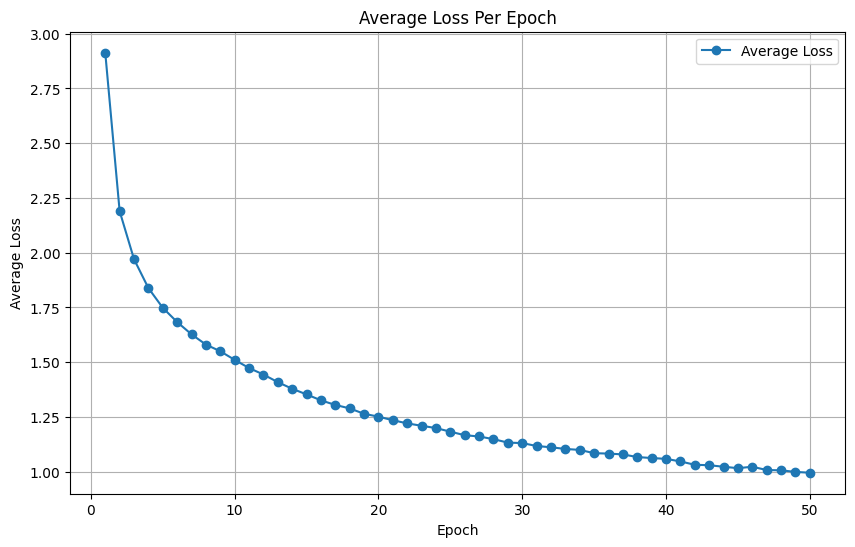

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(average_losses) + 1))  # Epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, average_losses, label='Average Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss Per Epoch')
plt.grid(True)
plt.legend()
plt.show()